# Analysis of interacting case for optimal variational parameters

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
import pandas as pd
import numpy as np

from vmc.interface import *
from vmc import run_all

from IPython.core.display import display

In [2]:
#sns.set(color_codes=True)

In [3]:
mass = 1.0
omega = 1.0

radius = 0.0043
beta = _lambda = 2.82843

num_particles = 50
num_dimensions = 3

step_length = 0.1

num_samples = int(2**17)
num_thermalization_steps = int(0.1*num_samples)

r_min = 0
r_max = 4
num_bins = 100


parameter_names = ["alpha"]
alpha = np.array([0.4974]).reshape(1, 1)
alpha_s = np.array([0.5]).reshape(1, 1)

kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [4]:
sampler_i = PySampler(
    PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, radius,
        spread=np.sqrt(step_length)
    ), PyEllipticalHarmonicOscillator(_lambda),
    PyImportanceMetropolis()
)

sampler_n = PySampler(
    PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, 0,
        spread=np.sqrt(step_length)
    ), PyEllipticalHarmonicOscillator(_lambda),
    PyImportanceMetropolis()
)

sampler_s = PySampler(
    PySimpleGaussian(
        num_particles, num_dimensions, mass, omega, spread=np.sqrt(step_length)
    ), PyHarmonicOscillator(),
    PyImportanceMetropolis()
)

sampler_i.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_n.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_s.initialize_one_body_densities(r_min, r_max, num_bins)

In [5]:
df_i = run_all(sampler_i, alpha, parameter_names, 0, **kwargs)
df_i["energy_per_particle"] = df_i["energy"]/num_particles

100%|██████████| 1/1 [00:19<00:00, 19.74s/it]


In [6]:
display(df_i)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.4974,127.308812,0.000001,0.001192,0.958405,19.717337,0.000519,0.022772,2.546176


In [7]:
df_n = run_all(sampler_n, alpha, parameter_names, 0, **kwargs)
df_n["energy_per_particle"] = df_n["energy"]/num_particles

100%|██████████| 1/1 [00:26<00:00, 26.35s/it]


In [8]:
display(df_n)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.4974,120.706973,4.967184e-08,0.000223,0.963257,26.233176,0.000011,0.003243,2.414139


In [9]:
df_s = run_all(sampler_s, alpha_s, parameter_names, 0, **kwargs)
df_s["energy_per_particle"] = df_s["energy"]/num_particles

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [10]:
display(df_s)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.5,75.0,0.0,0.0,0.985229,1.284523,0.0,0.0,1.5


In [11]:
bins_i = sampler_i.get_one_body_densities()
bins_n = sampler_n.get_one_body_densities()
bins_s = sampler_s.get_one_body_densities()
radii = np.linspace(r_min, r_max, num_bins)

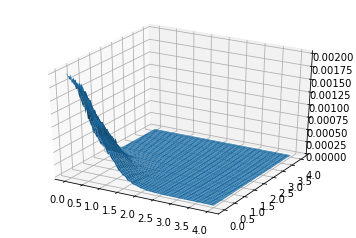

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
xv, yv = np.meshgrid(radii, radii)
ax.plot_surface(xv, yv, np.outer(bins_i[:, ::3], bins_i[:, ::3]))
plt.show()

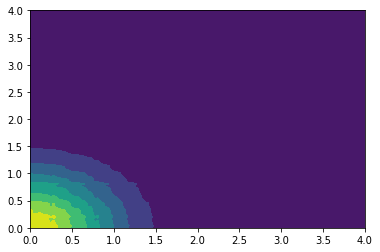

In [15]:
plt.contourf(radii, radii, np.outer(bins_i[:, ::3], bins_i[:, 1::3]))
plt.show()

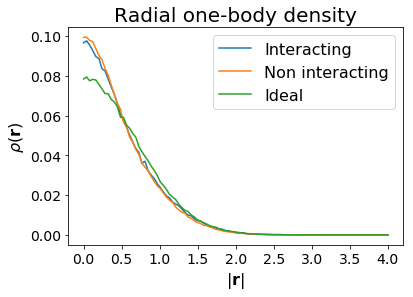

In [16]:
plt.plot(radii, np.linalg.norm(bins_i, axis=1), label=r"Interacting")
plt.plot(radii, np.linalg.norm(bins_n, axis=1), label=r"Non interacting")
plt.plot(radii, np.linalg.norm(bins_s, axis=1), label=r"Ideal")
plt.title(r"Radial one-body density", fontsize=20)
plt.xlabel(r"$|\mathbf{r}|$", fontsize=16)
plt.ylabel(r"$\rho(\mathbf{r})$", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="best", fontsize=16)
plt.savefig("../data/figures/problem_g.pdf")
plt.show()